# Creating and running an Optimization Model

In [24]:
!pip install docplex

In [25]:
import docplex.cp

In [26]:
# Initialize IBM Decision Optimization credentials
SVC_URL = "" 
SVC_KEY = ""

In [27]:
# Make sure the indentation is exactly as shown in the guide.
try:
   import matplotlib
   if matplotlib.__version__ < "1.4.3":
        !pip install --upgrade matplotlib
except:
   !pip install --user matplotlib

In [28]:
from docplex.cp.model import *
from sys import stdout
from collections import namedtuple

In [29]:
NB_HOUSES = 5
MAX_AMOUNT_OF_PERIODS = 318
HOUSES = range(1, NB_HOUSES + 1)
# All tasks must start and end between 0 and the max amount of periods.
period_domain = (0, MAX_AMOUNT_OF_PERIODS)

In [30]:
Task = (namedtuple("Task", ["name", "duration"]))
TASKS = {Task("masonry",   35),
         Task("carpentry", 15),
         Task("plumbing",  40),
         Task("ceiling",   15),
         Task("roofing",    5),
         Task("painting",  10),
         Task("windows",    5),
         Task("facade",    10),
         Task("garden",     5),
         Task("moving",     5),
        }

In [31]:
TaskPrecedence = (namedtuple("TaskPrecedence", ["beforeTask", "afterTask"]))
TASK_PRECEDENCES = {TaskPrecedence("masonry",   "carpentry"),
                    TaskPrecedence("masonry",   "plumbing"),
                    TaskPrecedence("masonry",   "ceiling"),
                    TaskPrecedence("carpentry", "roofing"),
                    TaskPrecedence("ceiling",   "painting"),
                    TaskPrecedence("roofing",   "windows"),
                    TaskPrecedence("roofing",   "facade"),
                    TaskPrecedence("plumbing",  "facade"),
                    TaskPrecedence("roofing",   "garden"),
                    TaskPrecedence("plumbing",  "garden"),
                    TaskPrecedence("windows",   "moving"),
                    TaskPrecedence("facade",    "moving"),
                    TaskPrecedence("garden",    "moving"),
                    TaskPrecedence("painting",  "moving"),
                   }

In [32]:
WORKERS = {"Joe", "Jack", "Jim"}
Skill = (namedtuple("Skill", ["worker", "task", "level"]))
SKILLS = {Skill("Joe",  "masonry",   9),
          Skill("Joe",  "carpentry", 7),
          Skill("Joe",  "ceiling",   5),
          Skill("Joe",  "roofing",   6),
          Skill("Joe",  "windows",   8),
          Skill("Joe",  "facade",    5),
          Skill("Joe",  "garden",    5),
          Skill("Joe",  "moving",    6),
          Skill("Jack", "masonry",   5),
          Skill("Jack", "plumbing",  7),
          Skill("Jack", "ceiling",   8),
          Skill("Jack", "roofing",   7),
          Skill("Jack", "painting",  9),
          Skill("Jack", "facade",    5),
          Skill("Jack", "garden",    5),
          Skill("Jim",  "carpentry", 5),
          Skill("Jim",  "painting",  6),
          Skill("Jim",  "windows",   5),
          Skill("Jim",  "garden",    9),
          Skill("Jim",  "moving",    8)
          }

In [33]:
# find_tasks: returns the task it refers to in the TASKS vector.
def find_tasks(name):
    return next(t for t in TASKS if t.name == name)

# find_skills: returns the skill it refers to in the SKILLS vector.
def find_skills(worker, task):
    return next(s for s in SKILLS if (s.worker == worker) and (s.task == task))

# find_max_level_skill: returns the tuple "skill" where a worker's level is the maximum for a given task.
def find_max_level_skill(task):
    st = [s for s in SKILLS if s.task == task]
    return next(sk for sk in st if sk.level == max([s.level for s in st]))

In [34]:
# Create the model container
mdl = CpoModel(name="HouseBuilding")

In [35]:
tasks = {}   # dict of interval variable for each house and task
for house in HOUSES:
    for task in TASKS:
        tasks[(house, task)] = interval_var(start=period_domain,
                                            end=period_domain,
                                            size=task.duration,
                                            name="house {} task {}".format(house, task))

In [36]:
wtasks = {}  # dict of interval variable for each house and skill
for house in HOUSES:
    for skill in SKILLS:
        iv = interval_var(name='H' + str(house) + '-' + skill.task + '(' + skill.worker + ')')
        iv.set_optional()
        wtasks[(house, skill)] = iv

In [37]:
for h in HOUSES:
    for p in TASK_PRECEDENCES:
        mdl.add(end_before_start(tasks[(h, find_tasks(p.beforeTask))], tasks[(h, find_tasks(p.afterTask))]))
        
for h in HOUSES:
    for t in TASKS:
        mdl.add(alternative(tasks[(h, t)], [wtasks[(h, s)] for s in SKILLS if (s.task == t.name)], 1))

for w in WORKERS:
    mdl.add(no_overlap([wtasks[(h, s)] for h in HOUSES for s in SKILLS if s.worker == w]))


In [38]:
obj = sum([s.level * presence_of(wtasks[(h, s)]) for s in SKILLS for h in HOUSES])
mdl.add(maximize(obj))

In [39]:
# Solve the model
print("\nSolving model....")
msol = mdl.solve(url=SVC_URL, key=SVC_KEY, TimeLimit=10)


Solving model....


# View the Solution

In [40]:
print("Solve status: " + msol.get_solve_status())
if msol.is_solution():
    stdout.write("Solve time: " + str(msol.get_solve_time()) + "\n")
    # Sort tasks in increasing begin order
    ltasks = []
    for hs in HOUSES:
        for tsk in TASKS:
            (beg, end, dur) = msol[tasks[(hs, tsk)]]
            ltasks.append((hs, tsk, beg, end, dur))
    ltasks = sorted(ltasks, key = lambda x : x[2])
    # Print solution
    print("\nList of tasks in increasing start order:")
    for tsk in ltasks:
        print("From " + str(tsk[2]) + " to " + str(tsk[3]) + ", " + tsk[1].name + " in house " + str(tsk[0]))
else:
    stdout.write("No solution found\n")

Solve status: Feasible
Solve time: 10.0831871033

List of tasks in increasing start order:
From 0 to 35, masonry in house 4
From 0 to 35, masonry in house 5
From 35 to 70, masonry in house 1
From 35 to 50, ceiling in house 5
From 50 to 90, plumbing in house 4
From 50 to 60, painting in house 5
From 70 to 105, masonry in house 3
From 90 to 130, plumbing in house 5
From 105 to 140, masonry in house 2
From 105 to 120, carpentry in house 3
From 130 to 145, ceiling in house 3
From 140 to 155, ceiling in house 4
From 145 to 160, ceiling in house 2
From 145 to 155, painting in house 3
From 155 to 170, carpentry in house 1
From 155 to 165, painting in house 4
From 160 to 200, plumbing in house 3
From 170 to 185, ceiling in house 1
From 185 to 195, painting in house 1
From 185 to 200, carpentry in house 5
From 200 to 240, plumbing in house 1
From 200 to 215, carpentry in house 4
From 215 to 230, carpentry in house 2
From 230 to 235, roofing in house 5
From 235 to 240, garden in house 5
From 235

# Bonus Section

In [41]:
POP_UP_GRAPHIC=False

import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
if not POP_UP_GRAPHIC:
    %matplotlib inline
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

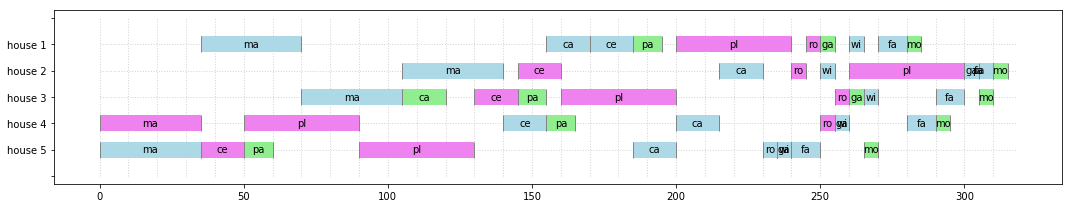

In [42]:
# Get just the first letter of each Task for easy display
def compact_name(name,n): return name[:n]

if msol and visu.is_visu_enabled():
    workers_colors = {}
    workers_colors["Joe"] = 'lightblue'
    workers_colors["Jack"] = 'violet'
    workers_colors["Jim"] = 'lightgreen'
    visu.timeline('Solution per houses', 0, MAX_AMOUNT_OF_PERIODS)
    for h in HOUSES:
        visu.sequence(name="house " + str(h))
        for s in SKILLS:
            wt = msol.get_var_solution(wtasks[(h,s)])
            if wt.is_present():
                color = workers_colors[s.worker]
                wtname = compact_name(s.task,2)
                visu.interval(wt, color, wtname)
    visu.show()

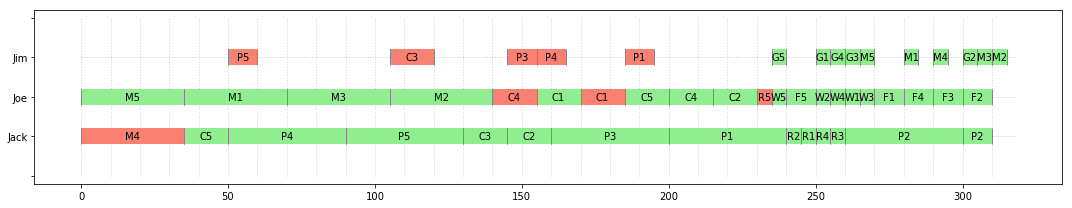

In [43]:
def compact_house_task(name):
    loc, task = name[1:].split('-', 1)
    return task[0].upper() + loc
if msol and visu.is_visu_enabled():
    visu.timeline('Solution per workers', 0, MAX_AMOUNT_OF_PERIODS)
    for w in WORKERS:
        visu.sequence(name=w)
        for h in HOUSES:
            for s in SKILLS:
                if s.worker == w:
                    wt = msol.get_var_solution(wtasks[(h,s)])
                    if wt.is_present():
                        ml = find_max_level_skill(s.task).level
                        if s.level == ml:
                            color = 'lightgreen'
                        else:
                            color = 'salmon'
                        wtname = compact_house_task(wt.get_name())
                        visu.interval(wt, color, wtname)
    visu.show()